In [1]:
import numpy as np
import math, json
from rdp import rdp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tqdm.notebook as tq
import pickle
from collections import defaultdict
import cairosvg
from PIL import Image
import glob
import svgwrite

In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/esp1/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

In [2]:
def get_bounds(data):
    minx, miny = 600, 600  
    maxx, maxy = 0, 0
    
    for i, (x, y, z) in enumerate(data): 
        if minx > x:
            minx = x
        if miny > y:
            miny = y 

        if maxx < x:
            maxx = x
        if maxy < y:
            maxy = y 
    return minx, maxx, miny, maxy

In [3]:
def convert_3d(drawing):
    out = []
    for item in drawing:
        char = list(item.keys())[0]
        stroke = item[char]
        if len(stroke) == 1:
            x, y = stroke[0]
            out.append([x, y, 0])
            out.append([x+5, y+5, 1])
            
        for i, point in enumerate(stroke):
            x, y = point 
            if i == len(stroke) - 1:
                out.append([x, y, 1])
            else:
                out.append([x, y, 0])
    return out

In [4]:
def make_square(im, min_size=256, fill_color=(255, 255, 255)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [5]:
def draw_strokes(data, factor=1, svg_filename = 'tmp/sample.svg', stroke_width = 3, square = False, return_res = False):
    min_x, max_x, min_y, max_y = get_bounds(data)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size = dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "M"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "M"
        elif (command != "L"):
            command = "L"
        else:
            command = ""
        x = float(data[i][0]) - min_x
        y = float(data[i][1]) - min_y
        lift_pen = data[i][2]
        p += command+str(x)+" "+str(y)+" "
    the_color = "black"
    
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    cairosvg.svg2png(url="tmp/sample.svg", write_to="tmp/sample.png")
    img = Image.open('tmp/sample.png')
    if square:
        img = make_square(img)
    if return_res:
        return img, dims 
    else:
        return img

In [6]:
#https:#jrgraphix.net/r/Unicode/0600-06FF
map_chars = {
    "\u0623":["\u0621", "\u0627"], # أ
    "\u0622":["\u0605", "\u0627"], # آ
    "\u0625":["\u0627", "\u0621"], # إ
    "\u0628":["\u066E", "."], # ب
    "\u062A":[".", ".", "\u066E"], # ت
    "\u062B":[".", ".", ".", "\u066E"], # ث 
    "\u062C":["\u062D", "."], # ج
    "\u062E":[".", "\u062D"], # خ
    "\u0630":[".", "\u062F"], # ذ
    "\u0632":[".", "\u0631"], # ز
    "\u0634":[".", ".", ".", "\u0633"], # ش
    "\u0636":[".", "\u0635"], # ض
    "\u0637":["\u0627", "\uFEBB"], # ط
    "\u0638":[".", "\u0627", "\uFEBB"], # ظ
    "\u063A":[".", "\u0639"], # غ
    "\u0641":[".", "\u066F"], # ف
    "\u0642":[".", ".", "\u066F"], # ق
    "\u06A4":[".", ".", ".", "\u066F"], # ڤ
    "\u0643":["\u0621", "\u0644"], # ك
    "\u0646":[".", "\u06BA"], # ن
    "\u0624":["\u0621", "\u0648"], # ؤ
    "\u064A":["\u0649", ".", "."], #ي
    "\u0626":["\u0621", "\u0649"], #ئ
    "\u0629":[".", ".", "\u0647"], #ه
}

In [7]:
def preprocess(text):
    char_comps = []
    
    diacritics = "[ًٌٍَُِّْ]"
    numbers = '0123456789'
    for diac in diacritics: 
        text = text.replace(diac, '')

    for num in numbers: 
        text = text.replace(num, '')
    
    outText = ""
    
    for i in range(len(text)):
    
        if (text[i] == " "):
            continue
    
        if text[i] in map_chars:
            if (i < len(text) - 1 and text[i] == "\u0643"):
                if text[i+1] != ' ':
                    char_comps.append({text[i] : '\uFEDB'})
                else:
                    char_comps.append({text[i] : map_chars[text[i]]})
            else:
                char_comps.append({text[i] : map_chars[text[i]]})
        else:
                char_comps.append({text[i] : text[i]})

    return char_comps

In [8]:
def concatenate(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for im in images[::-1]:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    return new_im

In [9]:
def generate_characters(file):
    char_drawings = []
    annot = file.split('/')[-1][:-5]
    char_comps = preprocess(annot)
    drawing = json.load(open(file))
    i = 0 
    for comp in char_comps:
        char = list(comp.keys())[0]
        j = i + len(comp[char])
        char_drawings.append({char:drawing[i:j]})
        i = j 
    return char_drawings

In [26]:
npy_files = glob.glob('server/larger_data/*')
file = np.random.choice(npy_files)
print(file)

server/larger_data/16عبد الله.json


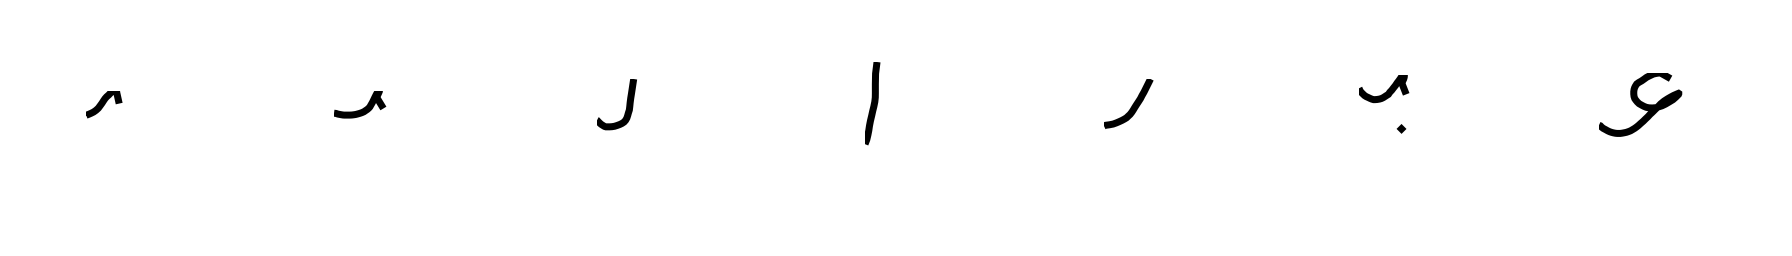

In [27]:
char_drawings = generate_characters(file)
images = []
for i, comp in enumerate(char_drawings):
    char, drawing = list(comp.items())[0]
    images.append(draw_strokes(convert_3d(drawing), square = True, stroke_width = 7))
concatenate(images)

In [50]:
import os
os.makedirs(f'characters', exist_ok = True)

In [49]:
!rm -r characters

In [51]:
npy_files = glob.glob('server/larger_data/*')

char_drawings = defaultdict(lambda  :[]) 

for file in npy_files:
    drawings = generate_characters(file)
    for i, comp in enumerate(drawings):
        char, drawing = list(comp.items())[0]
        os.makedirs(f'characters/{char}', exist_ok = True)
        img, res = draw_strokes(convert_3d(drawing), square = True, return_res = True, stroke_width = 5)
        ctr = 0
        img_path = f'characters/{char}/{ctr}.png'
        while f'{ctr}.png' in os.listdir(f'characters/{char}/'):
            ctr += 1
            img_path = f'characters/{char}/{ctr}.png'
        img.save(img_path)

In [95]:
import os
classes = os.listdir('characters')
images = defaultdict(lambda  :[]) 
for char in classes:
    if(len(glob.glob(f'characters/{char}/*.png')) > 100):
        for img_path in glob.glob(f'characters/{char}/*.png')[:100]:
            images[char].append(Image.open(img_path).convert('L').resize((64, 64)))

In [96]:
images.keys()

dict_keys(['ن', 'ر', 'ك', 'م', 'ا', 'ف', 'ع', 'ه', 'ت', 'و', 'ق', 'ي', 'ح', 'س', 'أ', 'ب', 'ل', 'د'])

In [97]:
np.random.choice([2, 3, 4])

2

In [129]:
x, y = [], []

for i, char in enumerate(images):
    for image in images[char]:
        y.append(char)
        x.append( 1- np.array(image).reshape(64**2)/255)


In [130]:
x = np.array(x)
print(x.shape)

(1800, 4096)


In [131]:
x[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
# x = StandardScaler().fit_transform(x)
tsne = TSNE(n_components=2).fit_transform(x)

(-80.0, 80.0)

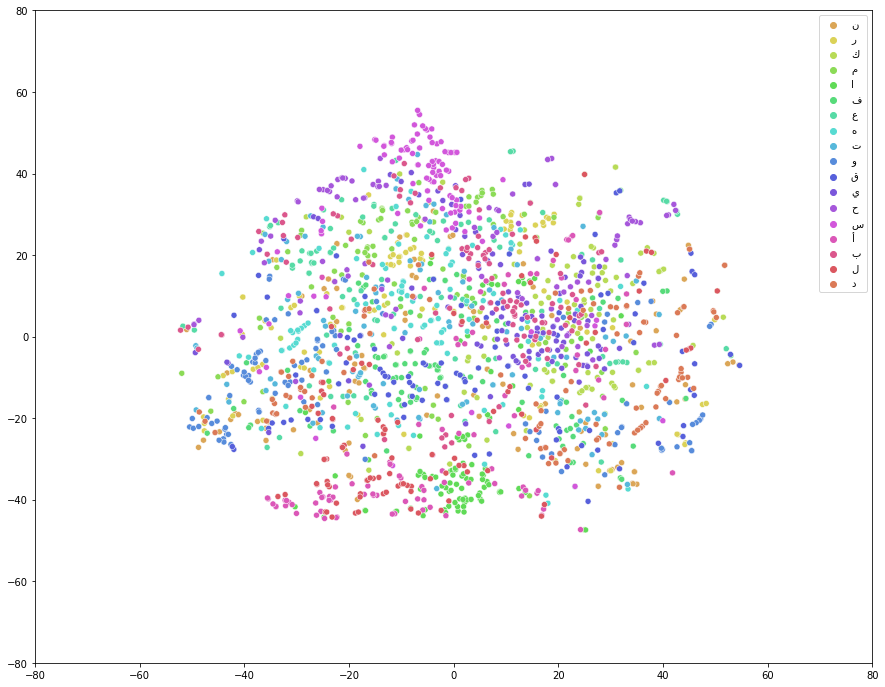

In [136]:
plt.figure(figsize = (15, 12))
sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = y, palette = sns.hls_palette(len(images),  h=.1), legend = 'full')
plt.xlim(-80, 80)
plt.ylim(-80, 80)